# Import and view the data

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps

path = 'C:/Users/Utente/Desktop/RecSys_Course_AT_PoliMi-master'
path1 = path + '/interactions_and_impressions.csv'
path2 = path + '/data_ICM_length.csv'
path3 = path + '/data_ICM_type.csv'


#reading the interaction matrix twice, one for impression discounting, I tried to copy it while making it equal to dummy = URM 
#but it did not work, so I did a dummy soln its fine. Also dummy needs to be read like this cause I need to be sure that 
#"Impressions" is in string format.


URM_interactions = pd.read_csv(path1)
ICM_length = pd.read_csv(path2)
ICM_type = pd.read_csv(path3)



C:\Users\Utente\AppData\Local\Temp\ipykernel_17032\2248175059.py:16: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  URM_interactions = pd.read_csv(path1)


In [2]:
"""interactions_and_impressions.csv : Contains the training set, describing implicit preferences expressed by the users.
-user_id : identifier of the user
-item_id : identifier of the item (TV series)
-impression_list : string containing the items that were present on the screen when the user interacted with the 
 item in column item_id. Not all interactions have a corresponding impressions list.
-data : "0" if the user watched the item, "1" if the user opened the item details page."""
URM_interactions

,UserID,ItemID,Impressions,Data
0,0,11,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1
1,0,21,NaN,0
2,0,21,NaN,0
3,0,21,"20,21,22,23,24,25,26,27,28,29",0
4,0,21,NaN,1
...,...,...,...,...
5826501,41628,20448,NaN,0
5826502,41628,20896,NaN,1
5826503,41628,21506,NaN,1
5826504,41628,22882,NaN,0


In [3]:
#IMPRESSION DISCOUNTING

dummy = URM_interactions.copy()

Impressions is a string of numbers seperated by ",". So I am using str.split to convert them into a list of numbers(ItemIDs)
dummy["Impressions"] = dummy["Impressions"].str.split(",")

#Filling the NaN values with a dummy number that does not exist in ItemID list, these will be dropped later
dummy["Impressions"] = dummy["Impressions"].fillna(99999)

#Explode basicly explodes the list of Impressions, every number in the list is seperated intro independent rows with 
#corresponding UserID ItemID and Data
URM_impressions = dummy.explode(["Impressions"])
URM_impressions["UserID"] = URM_impressions["UserID"].astype(int)
URM_impressions["ItemID"] = URM_impressions["ItemID"].astype(int)
URM_impressions["Impressions"] = URM_impressions["Impressions"].astype(int)

#Dropping the NaN values, we assigned them to dummy numbers otherwise explode does not work 
URM_impressions = URM_impressions.drop(URM_impressions[URM_impressions["Impressions"] == 99999].index)

#Dropping the itemID = Impression, meaning the item user interacted amongst the impression list
URM_impressions = URM_impressions[URM_impressions["ItemID"] != URM_impressions["Impressions"]]

#Now every impression is a seperate itemID that I can assign ratings. So I am selecting those columns and renaming Impressions
#as my new ItemID
URM_impressions = URM_impressions[["UserID","Impressions","Data"]]
URM_impressions.rename(columns = {'Impressions':'ItemID'}, inplace = True)

#I assign every Impression a rating of -1, meaning if the user did not interacted with the item, user did not like it
URM_impressions["Data"] = -1
URM_impressions["UserID"] = URM_impressions["UserID"].astype(int)
URM_impressions["ItemID"] = URM_impressions["ItemID"].astype(int)

#URM_impressions

In [4]:
URM_interactions.describe()

,UserID,ItemID,Data
count,5.826506e+06,5.826506e+06,5.826506e+06
mean,1.899451e+04,4.641730e+03,3.877156e-01
std,1.117126e+04,6.533349e+03,4.872291e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.315000e+03,3.370000e+02,0.000000e+00
50%,1.893600e+04,1.448000e+03,0.000000e+00
75%,2.831300e+04,6.016000e+03,1.000000e+00
max,4.162800e+04,2.450600e+04,1.000000e+00


In [5]:
URM_interactions = URM_interactions[["UserID","ItemID","Data"]]
#URM_interactions = pd.concat([URM_interactions,URM_impressions])

watched = 5;
open_descr = 3;

URM_interactions['Data'][URM_interactions['Data'] == 1] = 3 #dummy
URM_interactions['Data'][URM_interactions['Data'] == 0] = watched # watched
URM_interactions['Data'][URM_interactions['Data'] == 3] = open_descr # opened

C:\Users\Utente\AppData\Local\Temp\ipykernel_17032\2751399210.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  URM_interactions['Data'][URM_interactions['Data'] == 1] = 3 #dummy
C:\Users\Utente\AppData\Local\Temp\ipykernel_17032\2751399210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  URM_interactions['Data'][URM_interactions['Data'] == 0] = watched # watched
C:\Users\Utente\AppData\Local\Temp\ipykernel_17032\2751399210.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [6]:
User_Episode = URM_interactions[["UserID","ItemID","Data"]][URM_interactions['Data'] == watched]
User_Episode["Data"] = User_Episode.groupby(["UserID","ItemID"])["ItemID"].transform("count")
User_Episode.rename(columns = {'Data':'Watched'}, inplace = True)
User_Episode.reset_index()

ICM_length.rename(columns = {'item_id':'ItemID'}, inplace = True)

User_Episode = User_Episode.merge(ICM_length,on = "ItemID",how = "outer")
User_Episode = User_Episode.dropna(subset = ["UserID","Watched","data"])

User_Episode["Watched"]/=User_Episode["data"] + 1

User_Episode = User_Episode[["UserID", "ItemID","Watched"]]
User_Episode = User_Episode.drop_duplicates(subset = ["UserID" , "ItemID"])

User_Episode

,UserID,ItemID,Watched
0,0.0,21,0.107143
3,14.0,21,0.035714
4,15.0,21,0.071429
6,16.0,21,0.035714
7,25.0,21,0.035714
...,...,...,...
3567463,25890.0,21018,0.055556
3567464,26744.0,21018,0.055556
3567465,31457.0,21018,0.055556
3567466,32594.0,21018,0.055556


In [7]:
URM_interactions = URM_interactions.merge(User_Episode,on = ["UserID","ItemID"] ,how = "outer")
URM_interactions[URM_interactions["UserID"] == 0]
URM_interactions["Watched"] = URM_interactions[["Watched"]].fillna(1.0)
URM_interactions["Data"]*=URM_interactions["Watched"]


URM_interactions = URM_interactions.groupby(["UserID","ItemID"])["Data"].mean()
URM_interactions = URM_interactions.reset_index()

URM_interactions

,UserID,ItemID,Data
0,0,11,3.000000
1,0,21,0.375000
2,0,22,3.000000
3,0,24,3.000000
4,0,44,3.000000
...,...,...,...
1554635,41628,20448,2.500000
1554636,41628,20896,3.000000
1554637,41628,21506,3.000000
1554638,41628,22882,0.081967


In [8]:
ICM_length

,ItemID,feature_id,data
0,0,0,1
1,1,0,1
2,2,0,21
3,3,0,1
4,4,0,1
...,...,...,...
23086,27963,0,1
23087,27964,0,1
23088,27965,0,1
23089,27966,0,1


In [9]:
"""data_ICM_length.csv :
Contains the number of episodes of the items. TV series may have multiple episodes.

-item_id : identifier of the item
-feature_id : identifier of the feature, only one value (0) exists since this ICM only contains the feature "length"
-data : number of episodes. Some values may be 0 due to incomplete data."""
ICM_length.drop(columns = 'feature_id', inplace=True) # same feature is not needed
ICM_length 

,ItemID,data
0,0,1
1,1,1
2,2,21
3,3,1
4,4,1
...,...,...
23086,27963,1
23087,27964,1
23088,27965,1
23089,27966,1


In [10]:
ICM_length["data"] = ICM_length["data"].fillna(0)
ICM_length.loc[ICM_length["data"] > 1 , "data"] = 2
ICM_length

,ItemID,data
0,0,1
1,1,1
2,2,2
3,3,1
4,4,1
...,...,...
23086,27963,1
23087,27964,1
23088,27965,1
23089,27966,1


In [11]:
ICM_length.describe()

,ItemID,data
count,23091.000000,23091.000000
mean,14341.094452,1.430341
std,8236.943085,0.495135
min,0.000000,1.000000
25%,7169.000000,1.000000
50%,14405.000000,1.000000
75%,21646.500000,2.000000
max,27967.000000,2.000000


In [12]:
"""data_ICM_type.csv:
Contains the type of the items. An item can only have one type.
All types are anonymized and described only by a numerical identifier.

-item_id : identifier of the item
-feature_id : identifier of the type
-data : "1" if the item is described by the type"""
ICM_type.drop(columns = 'data', inplace=True) # same feature is not needed
ICM_type

,item_id,feature_id
0,0,1
1,1,3
2,2,4
3,3,1
4,4,3
...,...,...
23086,27963,1
23087,27964,2
23088,27965,1
23089,27966,1


In [13]:
#print ("The number of interactions is {}".format(len(URM_interactions)))
#print ("The number of users is {}".format(max(URM_interactions['UserID'])+1))
#print ("The number of items is {}".format(max(ICM_length['ItemID'])+1))
#print("Sparcity: {}%".format(1-len(int_and_impr)/(n_users*n_items)))

In [14]:
ICM_type.rename(columns = {'item_id':'ItemID'}, inplace = True)
#ICM_length.rename(columns = {'item_id':'ItemID'}, inplace = True)
#ICM_type = ICM_type.merge(ICM_length,on="ItemID",how = "outer")
ICM_type

,ItemID,feature_id
0,0,1
1,1,3
2,2,4
3,3,1
4,4,3
...,...,...
23086,27963,1
23087,27964,2
23088,27965,1
23089,27966,1


In [15]:
#ICM_type.rename(columns = {'data':'epNum'}, inplace = True)

In [16]:
ICM = URM_interactions.merge(ICM_type, on="ItemID", how="outer" )

ICM

,UserID,ItemID,Data,feature_id
0,0.0,11,3.0,1.0
1,2988.0,11,3.0,1.0
2,3144.0,11,2.5,1.0
3,3396.0,11,2.5,1.0
4,3567.0,11,3.0,1.0
...,...,...,...,...
1558096,NaN,27963,NaN,1.0
1558097,NaN,27964,NaN,2.0
1558098,NaN,27965,NaN,1.0
1558099,NaN,27966,NaN,1.0


In [17]:
ICM = ICM.dropna(subset=['UserID'])
ICM["feature_id"] = ICM["feature_id"].fillna(0)
ICM

C:\Users\Utente\AppData\Local\Temp\ipykernel_17032\2118415416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["feature_id"] = ICM["feature_id"].fillna(0)


,UserID,ItemID,Data,feature_id
0,0.0,11,3.0,1.0
1,2988.0,11,3.0,1.0
2,3144.0,11,2.5,1.0
3,3396.0,11,2.5,1.0
4,3567.0,11,3.0,1.0
...,...,...,...,...
1554635,32742.0,2538,3.0,0.0
1554636,34740.0,2538,3.0,0.0
1554637,37175.0,2538,5.0,0.0
1554638,37299.0,2538,5.0,0.0


In [18]:
URM_interactions["UserID"] = URM_interactions["UserID"].astype(int)
URM_interactions["ItemID"] = URM_interactions["ItemID"].astype(int)

In [19]:
mapped_id, original_id = pd.factorize(URM_interactions["UserID"].unique())

print("Unique UserID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_interactions["UserID"], ICM["UserID"],], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique UserID in the URM and ICM are {}".format(len(original_id)))

user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique UserID in the URM are 41629
Unique UserID in the URM and ICM are 41629


In [20]:
mapped_id, original_id = pd.factorize(URM_interactions["ItemID"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))
all_item_indices = pd.concat([URM_interactions["ItemID"], ICM["ItemID"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM are {}".format(len(original_id)))

item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM are 24507


In [21]:
mapped_id, original_id = pd.factorize(URM_interactions["Data"].unique())
data_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [22]:
mapped_id, original_id = pd.factorize(ICM["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [23]:
#mapped_id, original_id = pd.factorize(ICM["epNum"].unique())
#epNum_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [24]:
URM_interactions["ItemID"] = URM_interactions["ItemID"].map(item_original_ID_to_index)
URM_interactions["UserID"] = URM_interactions["UserID"].map(user_original_ID_to_index)
URM_interactions["Data"] = URM_interactions["Data"].map(data_original_ID_to_index)
URM_interactions

,UserID,ItemID,Data
0,0,0,0
1,0,1,1
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
1554635,41628,3700,3
1554636,41628,12694,0
1554637,41628,15132,0
1554638,41628,18128,1826


In [25]:
ICM["ItemID"] = ICM["ItemID"].map(item_original_ID_to_index)
ICM["UserID"] = ICM["UserID"].map(user_original_ID_to_index)
#ICM["epNum"] = ICM["epNum"].map(epNum_original_ID_to_index)
ICM["feature_id"] = ICM["feature_id"].map(feature_original_ID_to_index)


ICM



C:\Users\Utente\AppData\Local\Temp\ipykernel_17032\1065908835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["ItemID"] = ICM["ItemID"].map(item_original_ID_to_index)
C:\Users\Utente\AppData\Local\Temp\ipykernel_17032\1065908835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["UserID"] = ICM["UserID"].map(user_original_ID_to_index)
C:\Users\Utente\AppData\Local\Temp\ipykernel_17032\1065908835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,UserID,ItemID,Data,feature_id
0,0,0,3.0,0
1,2988,0,3.0,0
2,3144,0,2.5,0
3,3396,0,2.5,0
4,3567,0,3.0,0
...,...,...,...,...
1554635,32742,24506,3.0,3
1554636,34740,24506,3.0,3
1554637,37175,24506,5.0,3
1554638,37299,24506,5.0,3


In [26]:
n_users = len(user_original_ID_to_index)
n_features = len(feature_original_ID_to_index)
n_items = len(item_original_ID_to_index)
#n_episode = len(epNum_original_ID_to_index)


In [27]:
#CREATE URM

URM_all = sps.coo_matrix((np.ones(len(URM_interactions["UserID"].values)), 
                          (URM_interactions["UserID"].values, URM_interactions["ItemID"].values)), 
                         shape = (n_users, n_items))# change the structure here

from implicit.nearest_neighbours import bm25_weight


# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
#URM = bm25_weight(URM_all, K1=100, B=0.8)

# get the transpose since the most of the functions in implicit expect (user, item) sparse matrices instead of (item, user)
#URM_all = URM.tocsr()


In [28]:
#CREATE ICM
ICM_all = sps.csr_matrix((np.ones(len(ICM["ItemID"].values)), 
                          (ICM["ItemID"].values, ICM["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all

<24507x6 sparse matrix of type '<class 'numpy.float64'>'
	with 24507 stored elements in Compressed Sparse Row format>

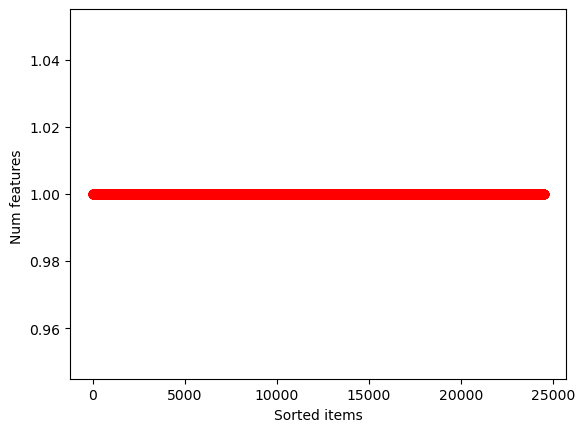

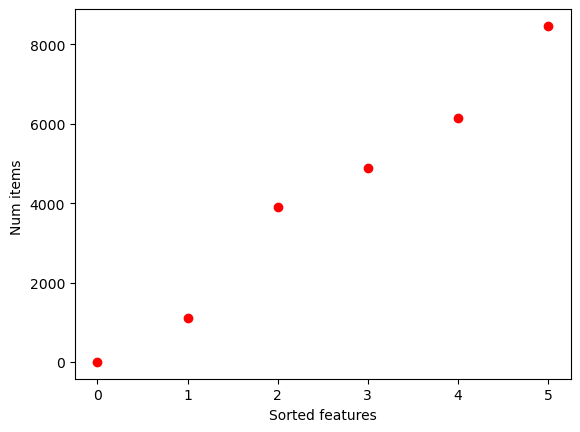

In [29]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

In [30]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.85)


In [31]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])


EvaluatorHoldout: Ignoring 1537 ( 3.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 865 ( 2.1%) Users that have less than 1 test interactions


In [ ]:
#results_df, _ = evaluator_test.evaluateRecommender(itemKNNCF)
#results_df

In [ ]:

from skopt.space import Real, Integer, Categorical

hyperparameters_range_dictionary = {
    "topK": Integer(5, 1000),
    "shrink": Integer(0, 1000),
    "similarity": Categorical(["cosine"]),
    "normalize": Categorical([True, False]),
}

from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt

recommender_class = ItemKNNCFRecommender

hyperparameterSearch = SearchBayesianSkopt(recommender_class,
                                         evaluator_validation=evaluator_validation,
                                         evaluator_test=evaluator_test)

from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
  
recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train],     # For a CBF model simply put [URM_train, ICM_train]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train_validation],     # For a CBF model simply put [URM_train_validation, ICM_train]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

import os

output_folder_path = "result_experiments/"

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
    
n_cases = 10  # using 10 as an example
n_random_starts = int(n_cases*0.3)
metric_to_optimize = "MAP"   
cutoff_to_optimize = 10

hyperparameterSearch.search(recommender_input_args,
                       recommender_input_args_last_test = recommender_input_args_last_test,
                       hyperparameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = n_random_starts,
                       save_model = "last",
                       output_folder_path = output_folder_path, # Where to save the results
                       output_file_name_root = recommender_class.RECOMMENDER_NAME, # How to call the files
                       metric_to_optimize = metric_to_optimize,
                       cutoff_to_optimize = cutoff_to_optimize,
                      )


In [ ]:
from Recommenders.DataIO import DataIO

data_loader = DataIO(folder_path = output_folder_path)
search_metadata = data_loader.load_data(recommender_class.RECOMMENDER_NAME + "_metadata.zip")

search_metadata.keys()

In [ ]:
hyperparameters_df = search_metadata["hyperparameters_df"]
hyperparameters_df

In [ ]:
result_on_validation_df = search_metadata["result_on_validation_df"]
result_on_validation_df

In [ ]:
result_best_on_test = search_metadata["result_on_last"]
result_best_on_test

In [32]:
best_hyperparameters ={'topK': 249, 'shrink': 0, 'similarity': 'jaccard', 'normalize': False}
best_hyperparameters

{'topK': 249, 'shrink': 0, 'similarity': 'jaccard', 'normalize': False}

In [33]:
best_hyperparams_ItemKNNCF = best_hyperparameters

from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_hyperparams_ItemKNNCF)

results_df, _ = evaluator_test.evaluateRecommender(itemKNNCF)
results_df

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 980.33 column/sec. Elapsed time 25.00 sec
EvaluatorHoldout: Processed 40764 (100.0%) in 18.19 sec. Users per second: 2241


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.041169,0.069075,0.064801,0.018557,0.030908,0.134025,0.064531,0.05035,0.295996,0.15694,...,0.979221,0.289846,0.979221,0.043227,9.201224,0.993808,0.085507,0.682043,3.552817,0.300391


In [ ]:
best_hyperparams_ItemKNNCF = best_hyperparameters
urm_train_validation = URM_train + URM_validation
best_recommender = ItemKNNCFRecommender(URM_all)
best_recommender.fit(**best_hyperparams_ItemKNNCF)


In [ ]:
path4 = path + '/data_target_users_test.csv'
users_to_recommend = pd.read_csv(path4)
users_to_recommend

In [ ]:

import scipy.sparse as sp
def prepare_submission(ratings: pd.DataFrame, users_to_recommend: np.array, urm_train: sp.csr_matrix, recommender: object):
    users_ids_and_mappings = user_original_ID_to_index.to_frame()
    users_ids_and_mappings = users_ids_and_mappings.drop_duplicates()
    users_ids_and_mappings = users_ids_and_mappings.reset_index(level=0)
    users_ids_and_mappings.columns = ["mapped_user_id","user_id"]
    users_ids_and_mappings = users_ids_and_mappings[users_ids_and_mappings.user_id.isin(users_to_recommend["user_id"])][["mapped_user_id", "user_id"]].drop_duplicates()
    
    items_ids_and_mappings = item_original_ID_to_index.to_frame()
    items_ids_and_mappings = items_ids_and_mappings.drop_duplicates()
    items_ids_and_mappings = items_ids_and_mappings.reset_index(level=0)
    items_ids_and_mappings.columns = ["mapped_item_id","item_id"]
    
    inv_map = dict(item_original_ID_to_index)
    mapping_to_item_id = {v: k for k, v in inv_map.items()}
    
    
    recommendation_length = 10
    submission = []
    for idx, row in users_ids_and_mappings.iterrows():
        user_id = row.user_id
        mapped_user_id = row.mapped_user_id
        
        recommendations = recommender.recommend(int(mapped_user_id),10)
        print(user_id ,",", *recommendations)
        rec_list = [mapping_to_item_id[ItemID] for ItemID in recommendations]
        submission.append((int(user_id), rec_list))
        
    return submission


In [ ]:
submission = prepare_submission(URM_all, users_to_recommend, URM_train_validation, best_recommender)


In [ ]:
submission


In [ ]:
def write_submission(submissions):
    with open("./submission.csv", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")

In [ ]:
write_submission(submission)